### Imports

In [1]:
from jax.config import config

#config.update("jax_debug_nans", False)
#config.update("jax_enable_x64", False)
#config.update("jax_platform_name", "gpu")

import parsmooth
from parsmooth.sequential import ieks as seq_ieks
from parsmooth.parallel import ekf
from parsmooth.utils import MVNormalParameters

In [2]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import tornadox

## Initial Value Problem

In [3]:
@jax.jit
def f(y, t):
    return 1. * y * (1 - y)

y0 = jnp.array([0.01])
t0, tmax = 0.0, 10.0

In [4]:
@jax.jit
def f(Y, t):
    mu = 1e2
    return jnp.array([Y[1], mu * ((1.0 - Y[0] ** 2) * Y[1] - Y[0])])

y0 = jnp.array([2.0, 0.0])
t0, tmax = 0.0, 6.3

In [5]:
#z = f(y0, None)
#z.block_until_ready()

## Definig the ODE Solver

In [6]:
# Fixed-step solver with step-size
dt = 1e-4

# Solver order
order = 3

### 1. Prior
Build the transition matrices (using `tornadox` because I'm lazy)

In [7]:
_d, _q = len(y0), order
diffusion = 0.1

iwp = tornadox.iwp.IntegratedWienerTransition(num_derivatives=_q, wiener_process_dimension=_d)
P0 = iwp.projection_matrix(0)
P1 = iwp.projection_matrix(1)
A, QS = iwp.non_preconditioned_discretize(dt)
Q = diffusion * (QS @ QS.T)
cpu_Q = jax.device_put(Q, jax.devices("cpu")[0])

@jax.jit
def tf(x, A):
    return A @ x

transition_function = jax.jit(partial(tf, A=A))
cpu_transition_function = jax.jit(partial(tf, A=jax.device_put(A, jax.devices("cpu")[0])))

### 2. Observation Model

In [8]:
def of(x, f, P0, P1):
    return P1@x - f(P0@x, None)

observation_function = jax.jit(partial(of, f=f, P0=P0, P1=P1))

In [9]:
R = 0 * jnp.eye(1)
cpu_R = jax.device_put(R, jax.devices("cpu")[0])


### 3. Data
We want the ODE to be satisfied == we want the difference to be zero == zero data:

In [10]:
ts = jnp.arange(t0, tmax, dt)
data = jnp.zeros((len(ts), _d))
data.device_buffer.device()
cpu_data = jax.device_put(data, jax.devices("cpu")[0])
print(data.shape)

(63000, 2)


## 4. Initial state
Again computed with `tornadox`:

In [11]:
m0, P0 = tornadox.init.TaylorMode()(f=lambda t, x: f(x, t), df=None, y0=y0, t0=0, num_derivatives=order)
m0, P0 = jnp.concatenate(m0.T), jnp.kron(jnp.eye(_d), P0)
cpu_m0, cpu_P0 = map(lambda z: jax.device_put(z, jax.devices("cpu")[0]), [m0, P0])
initial_guess = MVNormalParameters(m0, P0)
cpu_initial_guess = MVNormalParameters(cpu_m0, cpu_P0)

In [12]:
observation_function(m0)

DeviceArray([0., 0.], dtype=float64)


## Solve the ODE with `parsmooth`

In [13]:
init_lin = jnp.concatenate([0.5 * jnp.ones((data.shape[0] + 1, _d)), jnp.zeros((data.shape[0] + 1, _d*order))], 1)
init_lin = jnp.zeros((data.shape[0] + 1, _d*(order+1)))
init_lin = MVNormalParameters(init_lin, jnp.zeros((data.shape[0] + 1, _d*(order + 1), _d*(order + 1))))

### Plot

In [14]:
def plot_results(times, states, ax):
    means = states.mean[1:, 0]
    stds = states.cov[1:, 0, 0]
    ax.plot(times, means, marker='o', markersize=1)
    ax.fill_between(times, means - 3 * stds, means + 3 * stds, alpha=0.2)
    #ax.set_ylim(-0.2, 1.2)
    return ax

<AxesSubplot:>

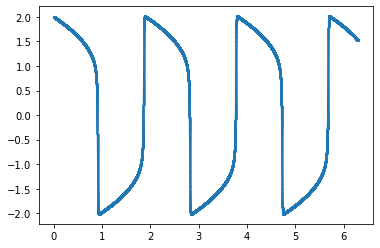

In [15]:
# Sequential EKF:
cpu_args = (cpu_initial_guess, cpu_data, cpu_transition_function, cpu_Q, observation_function, cpu_R, None)
_, filtered = parsmooth.sequential.ekf(*cpu_args)
fig, axes = plt.subplots(1)
plot_results(ts, filtered, ax=axes)

<AxesSubplot:>

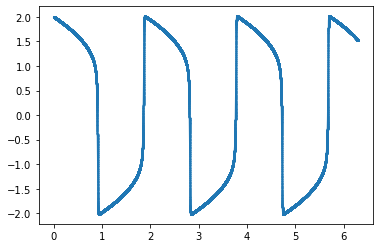

In [16]:
# Parallel IEKS:
args = (initial_guess, data, transition_function, Q, observation_function, R, filtered)

ieks_gpu = jax.jit(parsmooth.parallel.ieks, static_argnums=(2, 4, 7), backend="gpu")
ifiltered = ieks_gpu(*args, n_iter=10)

fig, axes = plt.subplots(1)
plot_results(ts, ifiltered, ax=axes)

In [17]:
raise Exception

Exception: 

# Some benchmarks

In [ ]:
ekf_cpu = jax.jit(parsmooth.sequential.ekf, static_argnums=(2, 4, 7), backend="cpu")
ekf_gpu = jax.jit(parsmooth.sequential.ekf, static_argnums=(2, 4, 7), backend="gpu")

parekf_cpu = jax.jit(parsmooth.parallel.ekf, static_argnums=(2, 4, 7), backend="cpu")
parekf_gpu = jax.jit(parsmooth.parallel.ekf, static_argnums=(2, 4, 7), backend="gpu")

ieks_cpu = jax.jit(parsmooth.parallel.ieks, static_argnums=(2, 4, 7), backend="cpu")
ieks_gpu = jax.jit(parsmooth.parallel.ieks, static_argnums=(2, 4, 7), backend="gpu")

The current state-of-the-art: Sequential extedended Kalman filtering

In [ ]:
%%timeit
filtered = ieks_cpu(*cpu_args)
filtered.mean.block_until_ready()

"Just using a GPU" slows it down:

Parallel extended Kalman filter with a fixed linearization:
(note that without a good initialization this does not provide a meaningful ODE solution!)

In [ ]:
%%timeit
filtered = ieks_gpu(*args)
filtered.mean.block_until_ready()